<a href="https://colab.research.google.com/github/sid0nair/3D-CNN-/blob/main/diffusion_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Jun  4 05:01:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!git clone https://github.com/ashawkey/stable-dreamfusion.git
%cd stable-dreamfusion

Cloning into 'stable-dreamfusion'...
remote: Enumerating objects: 1281, done.
remote: Counting objects: 100% (705/705), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 1281 (delta 616), reused 560 (delta 560), pack-reused 576 (from 1)
Receiving objects: 100% (1281/1281), 17.13 MiB | 14.53 MiB/s, done.
Resolving deltas: 100% (792/792), done.
/content/stable-dreamfusion


In [3]:
!pip install -r requirements.txt

  Cloning https://github.com/NVlabs/nvdiffrast/ to /tmp/pip-req-build-g2d_8qfl
  Running command git clone --filter=blob:none --quiet https://github.com/NVlabs/nvdiffrast/ /tmp/pip-req-build-g2d_8qfl
  Resolved https://github.com/NVlabs/nvdiffrast/ to commit 729261dc64c4241ea36efda84fbf532cc8b425b8
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-cr1pr1lg
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-cr1pr1lg
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.6 MB/s eta 0:00:00
   ━━━━

In [4]:
!pip install git+https://github.com/NVlabs/nvdiffrast/

  Cloning https://github.com/NVlabs/nvdiffrast/ to /tmp/pip-req-build-8y571dvj
  Running command git clone --filter=blob:none --quiet https://github.com/NVlabs/nvdiffrast/ /tmp/pip-req-build-8y571dvj
  Resolved https://github.com/NVlabs/nvdiffrast/ to commit 729261dc64c4241ea36efda84fbf532cc8b425b8
  Preparing metadata (setup.py) ... done


In [5]:
# Make sure the folder is here and inspect its top‐level files
!ls /content/stable-dreamfusion

activation.py  evaluation   meshutils.py	 requirements.txt
assets	       freqencoder  nerf		 scripts
config	       gridencoder  optimizer.py	 shencoder
data	       guidance     preprocess_image.py  taichi_modules
docker	       ldm	    pretrained		 tets
dpt.py	       LICENSE	    raymarching
encoding.py    main.py	    readme.md


In [6]:
!ls /content/stable-dreamfusion/guidance

clip_utils.py  if_utils.py  perpneg_utils.py  sd_utils.py  zero123_utils.py


In [7]:
# Cell A: Move into the repo (only if you aren’t already there)
%cd /content/stable-dreamfusion

/content/stable-dreamfusion


In [8]:
%%bash
# Make sure we are in the repository root
%cd /content/stable-dreamfusion

# Search for the exact string "precision_t" so we see all occurrences
grep -nr "precision_t" .

./guidance/sd_utils.py:46:        self.precision_t = torch.float16 if fp16 else torch.float32
./guidance/sd_utils.py:49:        pipe = StableDiffusionPipeline.from_pretrained(model_key, torch_dtype=self.precision_t)
./guidance/sd_utils.py:65:        self.scheduler = DDIMScheduler.from_pretrained(model_key, subfolder="scheduler", torch_dtype=self.precision_t)
./guidance/sd_utils.py:149:                result_hopefully_less_noisy_image = self.decode_latents(pred_x0.to(latents.type(self.precision_t)))
./guidance/sd_utils.py:152:                result_noisier_image = self.decode_latents(latents_noisy.to(pred_x0).type(self.precision_t))
./guidance/sd_utils.py:233:                result_hopefully_less_noisy_image = self.decode_latents(pred_x0.to(latents.type(self.precision_t)))
./guidance/sd_utils.py:236:                result_noisier_image = self.decode_latents(latents_noisy.to(pred_x0).type(self.precision_t))


bash: line 2: fg: no job control


In [11]:
%%bash
# 1) Change to the stable-dreamfusion folder (adjust if your path is different)
cd /content/stable-dreamfusion

# 2) Back up meshutils.py (optional, but recommended)
cp meshutils.py meshutils.py.bak

# 3) Comment out (or remove) the line that calls pml.Percentage
#    We’ll replace it with a “no‐op” so that it no longer tries to use pml.Percentage.
#    This assumes the offending call is on a single line; we’ll comment out that line.

sed -i '/meshing_merge_close_vertices/ s/^/#/' meshutils.py

In [13]:
%%bash
# Go to where stable-dreamfusion is cloned. Change this if your path differs.
cd /content/stable-dreamfusion

# If meshutils.py.bak exists, restore it:
if [ -f meshutils.py.bak ]; then
  mv meshutils.py.bak meshutils.py
  echo "Restored meshutils.py from backup."
else
  echo "No meshutils.py.bak found. Assuming meshutils.py is already original or manually edited."
fi

Restored meshutils.py from backup.


In [14]:
%%bash
cd /content/stable-dreamfusion

# Back up meshutils.py again (just in case)
cp meshutils.py meshutils.py.bak2

# Comment out any line that contains "meshing_merge_close_vertices"
sed -i 's/^\(\s*\)ms\.meshing_merge_close_vertices/#\1ms.meshing_merge_close_vertices/' meshutils.py

# Comment out any line that contains "meshing_remove_duplicate_faces"
sed -i 's/^\(\s*\)ms\.meshing_remove_duplicate_faces/#\1ms.meshing_remove_duplicate_faces/' meshutils.py

echo "Patched meshutils.py – both mesh‐cleanup calls are now commented out."

Patched meshutils.py – both mesh‐cleanup calls are now commented out.


In [16]:
%%bash
cd /content/stable-dreamfusion

# Back up the current meshutils.py (just in case)
cp meshutils.py meshutils.py.bak3

# Comment out every line that contains "ms.meshing_"
sed -i 's/^\(\s*\)ms\.meshing_/\\1#ms.meshing_/g' meshutils.py

In [18]:
%%bash
cd /content/stable-dreamfusion

# 1) Back up meshutils.py just in case
cp meshutils.py meshutils.py.backup_fin

# 2) Comment out any line that begins (with optional whitespace) with "ms.meshing_"
sed -i 's/^[[:space:]]*ms\.meshing_/#&/' meshutils.py

echo "Patched meshutils.py (all ms.meshing_ lines are now commented)."

Patched meshutils.py (all ms.meshing_ lines are now commented).


In [20]:
%%bash
cd /content/stable-dreamfusion

# If we have an original backup, restore it. Otherwise, proceed.
if [ -f meshutils.py.backup_fin ]; then
  mv meshutils.py.backup_fin meshutils.py
  echo "Restored meshutils.py from meshutils.py.backup_fin"
else
  echo "No backup_fin found; assuming meshutils.py is already original."
fi

# Now comment out all lines that start (after optional whitespace) with ms.meshing_
# This inserts a '#' at the start of each such line.
sed -i 's/^[[:space:]]*ms\.meshing_/#&/' meshutils.py

echo "Patched meshutils.py; all ms.meshing_ lines are now commented."

Restored meshutils.py from meshutils.py.backup_fin
Patched meshutils.py; all ms.meshing_ lines are now commented.


In [21]:
%%bash
cd /content/stable-dreamfusion

echo "----- meshutils.py around lines 70–110 -----"
sed -n '70,110p' meshutils.py
echo "---------------------------------------------"

----- meshutils.py around lines 70–110 -----
    print(f'[INFO] mesh decimation: {_ori_vert_shape} --> {verts.shape}, {_ori_face_shape} --> {faces.shape}')

    return verts, faces


def clean_mesh(verts, faces, v_pct=1, min_f=8, min_d=5, repair=True, remesh=True, remesh_size=0.01):
    # verts: [N, 3]
    # faces: [N, 3]

    _ori_vert_shape = verts.shape
    _ori_face_shape = faces.shape

    m = pml.Mesh(verts, faces)
    ms = pml.MeshSet()
    ms.add_mesh(m, 'mesh') # will copy!

    # filters
\1#ms.meshing_remove_unreferenced_vertices() # verts not refed by any faces

    if v_pct > 0:
#        ms.meshing_merge_close_vertices(threshold=pml.Percentage(v_pct)) # 1/10000 of bounding box diagonal

#    ms.meshing_remove_duplicate_faces() # faces defined by the same verts
\1#ms.meshing_remove_null_faces() # faces with area == 0

    if min_d > 0:
\1#ms.meshing_remove_connected_component_by_diameter(mincomponentdiag=pml.Percentage(min_d))
    
    if min_f > 0:
\1#ms.meshing_remove_conn

In [26]:
%%bash
# Move into the repository folder
%cd /content/stable-dreamfusion

# Customize these variables however you like:
PROMPT="an apple"
ITERS=1
LR=1e-3
RES=64
SEED=0
LAMBDA_EN=1e-4
NUM_STEPS=64
UPS_STEPS=32
WORKSPACE="trial"
CKPT="latest"

python main.py \
  -O2 \
  --text "${PROMPT}" \
  --workspace "${WORKSPACE}" \
  --iters ${ITERS} \
  --lr ${LR} \
  --w ${RES} \
  --h ${RES} \
  --seed ${SEED} \
  --lambda_entropy ${LAMBDA_EN} \
  --ckpt ${CKPT} \
  --save_mesh \
  --num_steps ${NUM_STEPS} \
  --upsample_steps ${UPS_STEPS}


Namespace(file=None, text='a banana', negative='', O=False, O2=True, test=False, six_views=False, eval_interval=1, test_interval=100, workspace='trial', seed='0', image=None, image_config=None, known_view_interval=4, IF=False, guidance=['SD'], guidance_scale=100, save_mesh=True, mcubes_resolution=256, decimate_target=50000.0, dmtet=False, tet_grid_size=128, init_with='', lock_geo=False, perpneg=False, negative_w=-2, front_decay_factor=2, side_decay_factor=10, iters=1, lr=0.001, ckpt='latest', cuda_ray=False, taichi_ray=False, max_steps=1024, num_steps=64, upsample_steps=32, update_extra_interval=16, max_ray_batch=4096, latent_iter_ratio=0.2, albedo_iter_ratio=0, min_ambient_ratio=0.1, textureless_ratio=0.2, jitter_pose=False, jitter_center=0.2, jitter_target=0.2, jitter_up=0.02, uniform_sphere_rate=0, grad_clip=-1, grad_clip_rgb=-1, bg_radius=1.4, density_activation='exp', density_thresh=10, blob_density=5, blob_radius=0.2, backbone='vanilla', optim='adan', sd_version='2.1', hf_key=Non

bash: line 2: fg: no job control
/content/stable-dreamfusion/nerf/utils.py:112: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/content/stable-dreamfusion/activation.py:7: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float)
/content/stable-dreamfusion/activation.py:13: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd
/content/stable-dreamfusion/raymarching/raymarching.py:33: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float32)
/content/stable-dreamfusion/raymarching/raymarching.py:66: FutureWarning: `torch.cuda.amp.cust

In [27]:
from google.colab import files
files.download("trial/mesh/mesh.obj")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Please upload a single .obj or .stl mesh file (click 'Choose Files').


Saving mesh (2).obj to mesh (2).obj
>>> Loading mesh from: mesh (2).obj


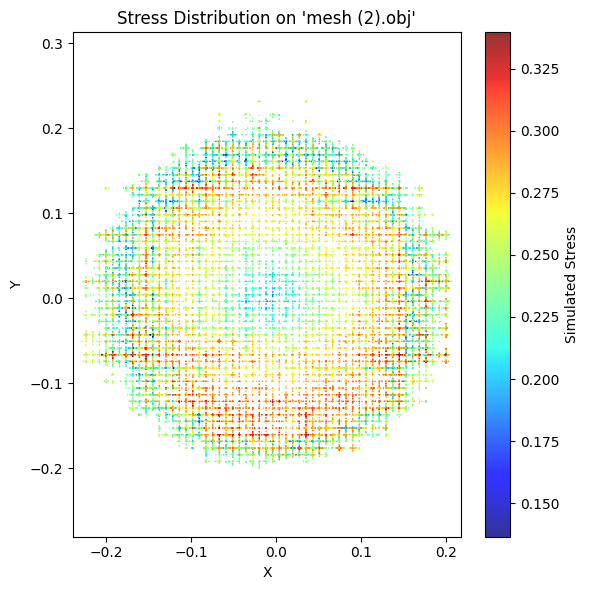

In [29]:
# Make sure to run this cell in Google Colab (or any environment where
# `google.colab.files.upload` is available). It will NOT pop up a tkinter dialog.

# 1) Imports
import numpy as np
import trimesh
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

# Colab‐specific import for file upload
from google.colab import files

# 2) Upload‐and‐load helper
def upload_and_load_mesh():
    """
    Prompts the user to upload a single .obj or .stl file.
    Returns a trimesh.Trimesh object.
    """
    print("Please upload a single .obj or .stl mesh file (click 'Choose Files').")
    uploaded = files.upload()  # widget opens; wait until you choose file

    if not uploaded:
        raise RuntimeError("No file was uploaded.")

    # Grab the first filename (Colab returns a dict of {filename: contents})
    filename = next(iter(uploaded.keys()))
    ext = filename.lower().rsplit(".", 1)[-1]
    if ext not in ("obj", "stl"):
        raise ValueError(f"Unsupported file extension: .{ext}. Please upload an .obj or .stl.")

    print(f">>> Loading mesh from: {filename}")
    mesh = trimesh.load_mesh(filename, force="mesh")
    if not isinstance(mesh, trimesh.Trimesh):
        raise ValueError("The uploaded file did not load as a valid Trimesh object.")
    return mesh, filename

# 3) (Optional) Build a 2D Delaunay triangulation in the XY‐plane
def generate_delaunay(mesh):
    """
    Given a Trimesh `mesh`, returns:
      - points   : a (N_vertices, 3) numpy array of vertex coordinates
      - elements : a (M_triangles, 3) integer array of Delaunay simplices (indices into points)

    Note: This triangulation is purely in 2D (X,Y). We ignore Z for connectivity.
    """
    points = mesh.vertices  # shape (N,3)
    # We only triangulate in XY, so drop the third coordinate
    delaunay = Delaunay(points[:, :2])
    elements = delaunay.simplices  # shape (num_triangles, 3)
    return points, elements

# 4) New "toy" stress‐simulation function
def simulate_stress(points, centroid_weight=1.0, height_weight=1.0):
    """
    Compute a simple “toy” stress value for each vertex in `points`.
    Here we combine:
      - radial distance from the centroid in XY‐plane
      - absolute height in Z
    Returns a 1D array of length N_vertices.

    stress_i = centroid_weight * (distance from centroid in XY)
             + height_weight * |Z_i|
    """
    # 4.a) compute centroid of all points
    centroid = points.mean(axis=0)  # shape (3,)

    # 4.b) radial distance from centroid in XY
    #    i.e. sqrt( (x - cx)^2 + (y - cy)^2 )
    delta_xy = points[:, :2] - centroid[:2]  # shape (N,2)
    radial_dist = np.linalg.norm(delta_xy, axis=1)  # shape (N,)

    # 4.c) absolute height = |Z|
    abs_height = np.abs(points[:, 2])  # shape (N,)

    # 4.d) combine them
    stress = centroid_weight * radial_dist + height_weight * abs_height
    return stress

# 5) Plotting routine (inline)
def plot_stress(points, stress, title=None):
    """
    Creates a 2D scatter‐plot of (X,Y) colored by 'stress'.
    points: (N,3) array. We plot X vs Y.
    stress: (N,) array of the same length.
    """
    plt.figure(figsize=(6,6))
    sc = plt.scatter(
        points[:, 0],
        points[:, 1],
        c=stress,
        cmap="jet",
        s=1,
        alpha=0.8,
        linewidths=0
    )
    plt.colorbar(sc, label="Simulated Stress")
    if title is not None:
        plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis("equal")
    plt.tight_layout()
    plt.show()

# 6) Main execution
def main():
    # 6.a) Upload and load the mesh
    mesh, filename = upload_and_load_mesh()

    # 6.b) (Optional) If you want connectivity / elements for future FEA,
    #       uncomment the next two lines. Otherwise, you can ignore `elements`.
    points, elements = generate_delaunay(mesh)
    # print(f"Generated Delaunay triangulation: {len(elements)} elements.")

    # 6.c) Simulate a “toy” stress
    #      You can tweak centroid_weight / height_weight if you like.
    stress = simulate_stress(points, centroid_weight=1.0, height_weight=1.0)

    # 6.d) Plot result
    title = f"Stress Distribution on '{filename}'"
    plot_stress(points, stress, title=title)

# 7) Run
if __name__ == "__main__":
    # In Colab, simply calling main() will auto‐execute when you run the cell.
    main()

In [15]:
%%bash
%cd /content/stable-dreamfusion

python main.py \
  -O2 \
  --test \
  --workspace "${WORKSPACE}" \
  --save_mesh \
  --max_ray_batch 1024

Namespace(file=None, text=None, negative='', O=False, O2=True, test=True, six_views=False, eval_interval=1, test_interval=100, workspace='', seed=None, image=None, image_config=None, known_view_interval=4, IF=False, guidance=['SD'], guidance_scale=100, save_mesh=True, mcubes_resolution=256, decimate_target=50000.0, dmtet=False, tet_grid_size=128, init_with='', lock_geo=False, perpneg=False, negative_w=-2, front_decay_factor=2, side_decay_factor=10, iters=10000, lr=0.001, ckpt='latest', cuda_ray=False, taichi_ray=False, max_steps=1024, num_steps=64, upsample_steps=32, update_extra_interval=16, max_ray_batch=1024, latent_iter_ratio=0.2, albedo_iter_ratio=0, min_ambient_ratio=0.1, textureless_ratio=0.2, jitter_pose=False, jitter_center=0.2, jitter_target=0.2, jitter_up=0.02, uniform_sphere_rate=0, grad_clip=-1, grad_clip_rgb=-1, bg_radius=1.4, density_activation='exp', density_thresh=10, blob_density=5, blob_radius=0.2, backbone='vanilla', optim='adan', sd_version='2.1', hf_key=None, fp16

bash: line 1: fg: no job control
/content/stable-dreamfusion/nerf/utils.py:112: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/content/stable-dreamfusion/activation.py:7: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float)
/content/stable-dreamfusion/activation.py:13: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd
/content/stable-dreamfusion/raymarching/raymarching.py:33: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float32)
/content/stable-dreamfusion/raymarching/raymarching.py:66: FutureWarning: `torch.cuda.amp.cust

CalledProcessError: Command 'b'%cd /content/stable-dreamfusion\n\npython main.py \\\n  -O2 \\\n  --test \\\n  --workspace "${WORKSPACE}" \\\n  --save_mesh \\\n  --max_ray_batch 1024\n'' returned non-zero exit status 1.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# ---------------------------------------
# 1) Sinusoidal Position Embeddings
# ---------------------------------------
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, timesteps):
        """
        timesteps: tensor of shape (B,), dtype torch.long
        returns: embeddings of shape (B, dim)
        """
        device = timesteps.device
        half_dim = self.dim // 2
        freq = torch.exp(
            -math.log(10000) * torch.arange(0, half_dim, device=device) / half_dim
        )
        args = timesteps[:, None].float() * freq[None]  # (B, half_dim)
        embeddings = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return embeddings  # (B, dim)

# ---------------------------------------
# 2) Small U-Net Blocks
# ---------------------------------------
class ResidualBlock(nn.Module):
    """
    A single residual block with group-norm → SiLU → Conv → group-norm → SiLU → Conv.
    Adds a time embedding (via a linear layer) to the feature map mid-block.
    """
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        self.block1 = nn.Sequential(
            nn.GroupNorm(num_groups=8, num_channels=in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        )
        self.block2 = nn.Sequential(
            nn.GroupNorm(num_groups=8, num_channels=out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        )
        # If channels differ, use a 1×1 conv for skip connection
        self.res_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) \
                        if in_channels != out_channels else nn.Identity()

    def forward(self, x, t):
        """
        x: (B, in_channels, H, W)
        t: (B, time_emb_dim)
        """
        h = self.block1(x)  # (B, out_channels, H, W)
        time_emb = self.time_mlp(t).unsqueeze(-1).unsqueeze(-1)  # (B, out_channels, 1, 1)
        h = h + time_emb
        h = self.block2(h)
        return h + self.res_conv(x)

class UNet(nn.Module):
    """
    A minimal U-Net with two downsample blocks, a bottleneck, and two upsample blocks.
    Predicts the noise given a noisy image x_t and timestep t.
    """
    def __init__(self, channels=3, base_channels=64, time_emb_dim=256):
        super().__init__()
        # Time‐embedding MLP
        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
        )

        # Down‐blocks
        self.conv1 = ResidualBlock(in_channels=channels, out_channels=base_channels, time_emb_dim=time_emb_dim)
        self.conv2 = ResidualBlock(in_channels=base_channels, out_channels=base_channels * 2, time_emb_dim=time_emb_dim)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = ResidualBlock(in_channels=base_channels * 2, out_channels=base_channels * 2, time_emb_dim=time_emb_dim)

        # Up‐blocks
        self.up_conv = nn.ConvTranspose2d(base_channels * 2, base_channels, kernel_size=2, stride=2)
        self.conv3 = ResidualBlock(in_channels=base_channels * 2, out_channels=base_channels, time_emb_dim=time_emb_dim)

        # Final 1×1 convolution back to channels
        self.final_conv = nn.Conv2d(base_channels, channels, kernel_size=1)

    def forward(self, x, t):
        """
        x: (B, 3, H, W)  noisy image
        t: (B,) integer timesteps
        """
        t_emb = self.time_embed(t)  # (B, time_emb_dim)

        # Down
        x1 = self.conv1(x, t_emb)           # (B, base_channels, H, W)
        x2 = self.pool(x1)                  # (B, base_channels, H/2, W/2)
        x2 = self.conv2(x2, t_emb)          # (B, base_channels*2, H/2, W/2)

        # Bottleneck
        x3 = self.pool(x2)                  # (B, base_channels*2, H/4, W/4)
        x3 = self.bottleneck(x3, t_emb)     # (B, base_channels*2, H/4, W/4)

        # Up
        x4 = self.up_conv(x3)               # (B, base_channels, H/2, W/2)
        x4 = torch.cat([x4, x2], dim=1)     # (B, base_channels*3, H/2, W/2) → after concat, feed into ResidualBlock expecting 2×channels from conv2 + 1×from up
        x4 = self.conv3(x4, t_emb)          # (B, base_channels, H/2, W/2)

        # Final conv (upsampled to H×W by unpooling)
        # Note: We skipped a second unpool for simplicity. If you want full H×W, you can pool/unpool symmetrical.
        # Here, since conv2 and conv3 both work at H/2, we use pool only once. For H/2→H/2 → final:
        return self.final_conv(x4)          # (B, 3, H/2, W/2) if you want full size, add an upsample to (H, W) here.


In [12]:
# ---------------------------------------
# 3) Diffusion (DDPM) Class
# ---------------------------------------
class Diffusion(nn.Module):
    def __init__(self, model, img_size, timesteps=1000, beta_start=1e-4, beta_end=2e-2):
        """
        model: your U-Net denoiser
        img_size: resolution (e.g., 64)
        timesteps: T in the DDPM
        beta_start, beta_end: linear noise schedule
        """
        super().__init__()
        self.model = model
        self.timesteps = timesteps
        self.img_size = img_size

        # Linear β schedule from beta_start → beta_end over T timesteps
        self.betas = torch.linspace(beta_start, beta_end, timesteps)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x0, t):
        """
        x0: (B, 3, H, W) original images in [−1,1] or [0,1]
        t: (B,) integer timesteps between [0, T-1]
        returns: x_t and the actual noise added
        """
        # Gather ᾱ_t (cumulative product up to t) for each sample
        a_cumprod_t = self.alphas_cumprod[t].sqrt()                   # (B,)
        one_minus_a_cumprod_t = (1 - self.alphas_cumprod[t]).sqrt()   # (B,)

        noise = torch.randn_like(x0)
        x_t = (
            a_cumprod_t[:, None, None, None] * x0
            + one_minus_a_cumprod_t[:, None, None, None] * noise
        )
        return x_t, noise

    def forward(self, x0):
        """
        Single training step:
        - Sample random t
        - Add noise x_t ← q(x_t | x0)
        - Predict the noise with the U-Net
        - Compute MSE between predicted noise and true noise
        """
        B = x0.shape[0]
        device = x0.device
        t = torch.randint(0, self.timesteps, (B,), device=device).long()  # (B,)
        x_t, noise = self.add_noise(x0, t)
        pred_noise = self.model(x_t, t)
        loss = F.mse_loss(pred_noise, noise)
        return loss

    @torch.no_grad()
    def sample(self, n_samples, device):
        """
        Generates images by reversing the diffusion process:
        - Start from pure Gaussian noise
        - For t from T−1…0, predict ε_θ(x_t, t), then compute x_{t−1}
        """
        x = torch.randn(n_samples, 3, self.img_size, self.img_size, device=device)
        for t in reversed(range(self.timesteps)):
            t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
            predicted_noise = self.model(x, t_batch)

            beta_t = self.betas[t]
            alpha_t = self.alphas[t]
            alpha_cumprod_t = self.alphas_cumprod[t]

            # Estimate x0 from predicted noise
            x0_pred = (x - beta_t.sqrt() * predicted_noise) / alpha_t.sqrt()
            if t > 0:
                noise = torch.randn_like(x)
                posterior_mean = alpha_t.sqrt() * x0_pred
                posterior_var = beta_t
                x = posterior_mean + posterior_var.sqrt() * noise
            else:
                x = x0_pred
        return x

In [13]:
if __name__ == "__main__":
    img_size = 64
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Instantiate U-Net and Diffusion
    unet = UNet(channels=3, base_channels=64, time_emb_dim=256).to(device)
    diffusion = Diffusion(unet, img_size=img_size, timesteps=1000).to(device)
    optimizer = torch.optim.Adam(diffusion.parameters(), lr=1e-4)

    # Dummy loop: replace `x0 = ...` with real batch from your DataLoader
    for epoch in range(10):
        x0 = torch.randn(8, 3, img_size, img_size, device=device)  # replace with real data
        loss = diffusion(x0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"[Epoch {epoch+1}] Training loss: {loss.item():.4f}")

    # After training, sample 4 new images:
    samples = diffusion.sample(n_samples=4, device=device)
    print("Generated samples tensor shape:", samples.shape)

ValueError: num_channels must be divisible by num_groups